In [9]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from itertools import repeat
from functools import reduce

In [25]:
def sum_fun(fun1,fun2):
    return (lambda x:fun1(x)+fun2(x))
def sum_funs(funs):
    return reduce(sum_fun,funs)
funs = [(lambda x:x),(lambda x:-x),(lambda x:3),(lambda x:x),(lambda x:3),(lambda x:3)]
sum_funs(funs)(4)

13

In [62]:
class gammaflash_generator:
    '''
    generates gammaflash-like signal
    
    Parameters
    t_s        : array-like, list of starting times of gammaflashes
    H_s        : float or array-like, list of amplitudes H of gammaflashes
    sigma_s    : float or array-like, list of smoothing factor of gammaflashes
    tau1_s     : float or array-like, list of decay time constant of fast components of gammaflashes
    tau2_s     : float or array-like, list of decay time constant of slow components of gammaflashes
    background : float, mean background level
    t_plot     : array, list of times to be plotted
    
    Methods
    signal_get : returns the realization of the gammaflashes with time and data arrays t_plot and x_plot
    signal_get_noise : same as above but adds a gaussian noise that is rms*max(signal)
    '''
    def __init__(self,t_s,H_s,sigma_s,tau1_s,tau2_s,background):
        if not hasattr(H_s,'__iter__'):
            H_s = repeat(H_s)
        if not hasattr(sigma_s,'__iter__'):
            sigma_s = repeat(sigma_s)
        if not hasattr(tau1_s,'__iter__'):
            tau1_s = repeat(tau1_s)
        if not hasattr(tau2_s,'__iter__'):
            tau2_s = repeat(tau2_s)
        self.t_s = t_s
        self.H_s = H_s
        self.sigma_s = sigma_s
        self.tau1_s = tau1_s
        self.tau2_s = tau2_s
        self.background = background
    def signal_get(self):
        t_plot = np.linspace(0,5000,10000)
        x_plot = self.background*np.ones_like(t_plot)
        for t_start,H,sigma,tau_1,tau_2 in zip(self.t_s,self.H_s,self.sigma_s,self.tau1_s,self.tau2_s):
            x_plot += self._generator(H,sigma,tau_1,tau_2)(t_plot-t_start)
        return t_plot,x_plot
    def signal_get_noise(self,sigma):
        t_plot,x_plot = self.signal_get()
        return t_plot,np.random.normal(x_plot,sigma)
    def _generator(self,H,sigma,tau_1,tau_2):
        return (lambda t: H*(np.exp((sigma**2-2*t*tau_1)/(2*tau_1**2))*
                        (1+scipy.special.erf(t/(np.sqrt(2)*sigma)-(np.sqrt(2)*sigma)/(2*tau_1)))
                        -np.exp((sigma**2-2*t*tau_2)/(2*tau_2**2))*
                        (1+scipy.special.erf(t/(np.sqrt(2)*sigma)-(np.sqrt(2)*sigma)/(2*tau_2)))))
    

Un approccio prettamente di tipo funzionale (che sarebbe preferibile per evitare di specificare in codice t_plot) non sembra funzionare per una questione di variabili locali

In [55]:
def generator(H,sigma,tau_1,tau_2):
        return (lambda t: H*(np.exp((sigma**2-2*t*tau_1)/(2*tau_1**2))*
                        (1+scipy.special.erf(t/(np.sqrt(2)*sigma)-(np.sqrt(2)*sigma)/(2*tau_1)))
                        -np.exp((sigma**2-2*t*tau_2)/(2*tau_2**2))*
                        (1+scipy.special.erf(t/(np.sqrt(2)*sigma)-(np.sqrt(2)*sigma)/(2*tau_2)))))
def signal_get(t_s,H_s,sigma_s,tau1_s,tau2_s,background):
    def sum_fun(fun1,fun2):
        return (lambda x: fun1(x)+fun2(x))
    listona = list(zip(t_s,repeat(H_s),repeat(sigma_s),repeat(tau1_s),repeat(tau2_s)))
    print(listona)
    gammaflashes = [(lambda t: np.ones_like(t)*background)] + [(lambda t: generator(H,sigma,tau_1,tau_2)(t-t_start)) 
                                                                        for t_start,H,sigma,tau_1,tau_2 in 
                                                                        listona]
    return reduce(sum_fun,gammaflashes)

[(0, 50, 10, 230, 30), (1000, 50, 10, 230, 30), (2000, 50, 10, 230, 30)]


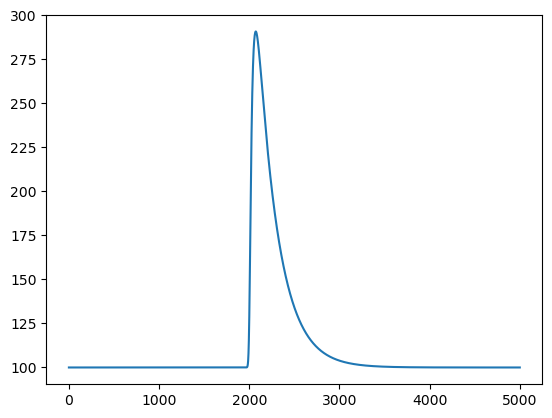

In [63]:
signal_fun = signal_get([0,1000,2000],50,10,230,30,100)
t_plot = np.linspace(0,5000,5000)
x_plot = signal_fun(t_plot)
plt.plot(t_plot,x_plot)

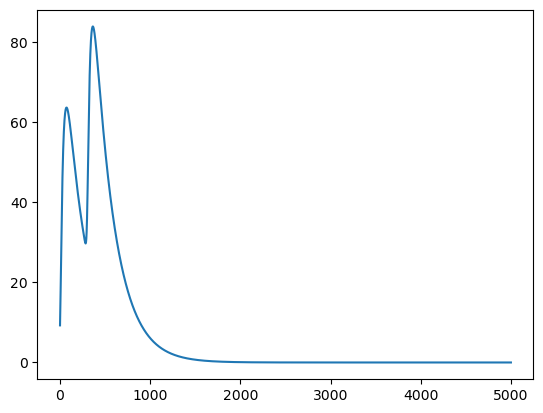

In [66]:
t_plot,x_plot = gammaflash_generator([0,300],50,10,230,30,0).signal_get()
plt.plot(t_plot,x_plot)

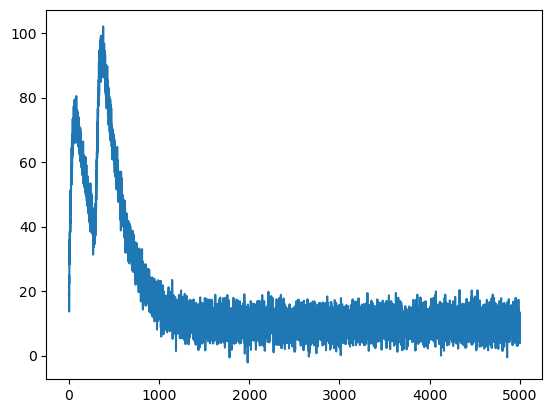

In [73]:
t_plot,x_plot = gammaflash_generator([0,300],50,10,230,30,10).signal_get_noise(3)
plt.plot(t_plot,x_plot)